In [1]:
# Auto-configure repo path and compute device (GPU/MPS/CPU)
import sys
from pathlib import Path

try:
    from utils.path_helpers import add_repo_root_to_sys_path
except Exception:
    cur = Path.cwd()
    for parent in [cur] + list(cur.parents):
        if (parent / "requirements.txt").exists() or (parent / ".git").exists():
            sys.path.insert(0, str(parent))
            break
    from utils.path_helpers import add_repo_root_to_sys_path

add_repo_root_to_sys_path()

from utils.device import get_device, backend_info, backend_name, ensure_seed
print(f"Using backend: {backend_info()}")
ensure_seed(42)

# For PyTorch 2.x, set default device so tensors/models go there automatically
try:
    import torch  # noqa: F401
    if backend_name() in ("torch_cuda", "torch_mps") and hasattr(torch, "set_default_device"):
        torch.set_default_device("cuda" if backend_name() == "torch_cuda" else "mps")
        print(f"torch default device set to {torch.get_default_device()}")
except Exception:
    pass

Using backend: Backend=MLX version=0.29.3 device=DeviceType.gpu


# Project 14: Pretraining a Tiny Transformer from Scratch

## Goal
Train a transformer from random weights using **next-token prediction** (causal language modeling). Observe loss curves, generation quality, and how a model learns language patterns purely from data.

## Learning Objectives
- Understand causal language modeling loss: predict next token given context
- Train end-to-end: data → tokenizer → transformer → loss → backprop → generation
- Observe training dynamics: loss curves, convergence, overfitting
- Implement data loaders, train loops, checkpointing, generation
- Visualize what embeddings + attention heads learn
- Compare tiny model performance to RNN baseline (Project 11.75)
- Understand why pretraining at scale is critical (billions of tokens → emergent abilities)

## Prerequisites
- Project 12 (Transformer): Know the architecture you're training
- Project 13 (Tokenization): Understand how text → token sequences
- Project 12.1-12.25 (Attention, Embeddings): Know the components being trained

## What You'll Build
- Full training loop: data loading → forward pass → loss → backward pass → optimization
- Character-level transformer (~20-50M parameters)
- Training curves: loss vs. epoch, train vs. validation
- Checkpoints: save best model weights
- Generation: sample from trained model (greedy + nucleus sampling)
- Attention visualizations and embedding analysis

## Estimated Time
- Code setup: 30 min
- Training (on CPU): 4-12 hours; (on GPU/MPS): 30-60 min
- Analysis: 1-2 hours

## Usage Guide

This notebook:
1. Downloads Shakespeare text data
2. Tokenizes with character-level or BPE tokenizer
3. Creates train/val splits and data loaders
4. Defines transformer architecture
5. Implements training loop with checkpointing
6. Generates text and analyzes learned representations

Key functions:
- `train_epoch()` → forward pass + loss + backward + step
- `evaluate()` → compute validation loss without training
- `generate()` → sample tokens from model (greedy or nucleus)
- `plot_training()` → visualize loss curves
- `analyze_embeddings()` → t-SNE, frequency analysis

---

## Model Configuration
```
Vocabulary: 5000-10000 tokens
Dimension: 384
Heads: 6
Layers: 4-6
Parameters: ~20-50M
Dataset: Shakespeare (~5MB)
Training time on M4: 4-12 hours
```

In [2]:
# Setup
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Training on: {device}")

Training on: mps


In [3]:
# 1) Download Shakespeare Dataset
import urllib.request

data_dir = Path('data/raw')
data_dir.mkdir(parents=True, exist_ok=True)

shakespeare_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
shakespeare_path = data_dir / 'shakespeare.txt'

if not shakespeare_path.exists():
    print('Downloading Shakespeare dataset...')
    urllib.request.urlretrieve(shakespeare_url, shakespeare_path)
    print('Download complete!')
else:
    print('Dataset already exists')

# Load and inspect
with open(shakespeare_path, 'r', encoding='utf-8') as f:
    text = f.read()

print(f'\nDataset size: {len(text):,} characters')
print(f'Unique characters: {len(set(text))}')
print(f'\nFirst 500 characters:')
print(text[:500])

Dataset already exists

Dataset size: 1,115,394 characters
Unique characters: 65

First 500 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [4]:
# 2) Build Character-Level Tokenizer
class CharTokenizer:
    def __init__(self, text):
        chars = sorted(list(set(text)))
        self.vocab_size = len(chars)
        self.char_to_id = {ch: i for i, ch in enumerate(chars)}
        self.id_to_char = {i: ch for ch, i in self.char_to_id.items()}
        
    def encode(self, text):
        return [self.char_to_id[ch] for ch in text]
    
    def decode(self, ids):
        return ''.join([self.id_to_char[i] for i in ids])

# Create tokenizer
tokenizer = CharTokenizer(text)
print(f'Vocabulary size: {tokenizer.vocab_size}')
print(f'Vocabulary: {list(tokenizer.char_to_id.keys())}')

# Test encoding/decoding
sample = "Hello, world!"
encoded = tokenizer.encode(sample)
decoded = tokenizer.decode(encoded)
print(f'\nTest encoding:')
print(f'  Original: {sample}')
print(f'  Encoded: {encoded}')
print(f'  Decoded: {decoded}')

Vocabulary size: 65
Vocabulary: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

Test encoding:
  Original: Hello, world!
  Encoded: [20, 43, 50, 50, 53, 6, 1, 61, 53, 56, 50, 42, 2]
  Decoded: Hello, world!


In [5]:
# 3) Prepare Train/Val Split
# Encode entire dataset
data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
print(f'Total tokens: {len(data):,}')

# Split: 90% train, 10% validation
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

print(f'Train tokens: {len(train_data):,}')
print(f'Val tokens: {len(val_data):,}')

Total tokens: 1,115,394
Train tokens: 1,003,854
Val tokens: 111,540


In [6]:
# 4) Load Transformer Model (from project 12)
# Import model classes from previous notebook
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def forward(self, x, mask=None):
        batch_size = x.size(0)
        Q = self.W_q(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, V)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_o(output)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        attn_output = self.attention(x, mask)
        x = self.norm1(x + self.dropout1(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x

class GPTModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_len=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.token_embedding.weight  # Weight tying
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
    def forward(self, idx, targets=None):
        batch_size, seq_len = idx.size()
        positions = torch.arange(0, seq_len, dtype=torch.long, device=idx.device).unsqueeze(0)
        
        # Causal mask
        mask = torch.tril(torch.ones(seq_len, seq_len, device=idx.device)).unsqueeze(0).unsqueeze(0)
        
        # Embeddings
        x = self.token_embedding(idx) + self.position_embedding(positions)
        x = self.dropout(x)
        
        # Transformer blocks
        for block in self.blocks:
            x = block(x, mask)
        
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        
        return logits, loss

# Create model
config = {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 256,
    'num_heads': 8,
    'num_layers': 4,
    'd_ff': 1024,
    'max_len': 256,
    'dropout': 0.1
}

model = GPTModel(**config).to(device)
print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Model size: ~{sum(p.numel() for p in model.parameters()) * 4 / 1e6:.1f} MB')

Model parameters: 3,241,728
Model size: ~13.0 MB


In [7]:
# 5) Create Data Loaders
def get_batch(data, batch_size, block_size):
    """Get a batch of data for training"""
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Test batch generation
batch_size = 32
block_size = 128
x_batch, y_batch = get_batch(train_data, batch_size, block_size)
print(f'Input batch shape: {x_batch.shape}')
print(f'Target batch shape: {y_batch.shape}')
print(f'\nExample: first sequence (first 50 chars)')
print(f'Input:  {tokenizer.decode(x_batch[0, :50].tolist())!r}')
print(f'Target: {tokenizer.decode(y_batch[0, :50].tolist())!r}')

Input batch shape: torch.Size([32, 128])
Target batch shape: torch.Size([32, 128])

Example: first sequence (first 50 chars)
Input:  'Call it so.\n\nProvost:\nAway, sir! you must go.\n\nCLA'
Target: 'all it so.\n\nProvost:\nAway, sir! you must go.\n\nCLAU'


In [8]:
# 6) Training Loop (enhanced: versioned checkpoints, CSV logging, early stopping)
from tqdm import tqdm
import csv, datetime
from pathlib import Path

# Hyperparameters
max_iters = 5000  # adjust as needed
learning_rate = 3e-4
eval_interval = 250
eval_iters = 100
patience = 6              # number of evaluation windows without improvement before stopping
save_every = 500          # versioned checkpoint interval

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

# Paths for artifacts
cur = Path().resolve()
ckpt_dir = cur / 'checkpoints'
ckpt_dir.mkdir(exist_ok=True)
latest_ckpt = cur / 'shakespeare_transformer.pt'
best_ckpt = cur / 'shakespeare_transformer_best.pt'
log_csv = cur / 'training_log.csv'

# CSV logging helper
def log_row(step, train_loss, val_loss, is_best):
    write_header = not log_csv.exists()
    with open(log_csv, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=[
            'timestamp','step','train_loss','val_loss','is_best','lr'
        ])
        if write_header:
            writer.writeheader()
        writer.writerow({
            'timestamp': datetime.datetime.now().isoformat(timespec='seconds'),
            'step': step,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'is_best': int(is_best),
            'lr': learning_rate
        })

@torch.no_grad()
def estimate_loss():
    """Estimate average loss on train and val sets"""
    model.eval()
    out = {}
    for split, data in [('train', train_data), ('val', val_data)]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(data, batch_size, block_size)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = float(losses.mean())
    model.train()
    return out

print('Starting enhanced training...')
best_val = float('inf')
no_improve_count = 0
for iter in tqdm(range(max_iters), desc='Training'):
    # Evaluate loss periodically
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        tr_loss = losses['train']
        va_loss = losses['val']
        train_losses.append(tr_loss)
        val_losses.append(va_loss)
        improved = va_loss < best_val - 1e-6
        if improved:
            best_val = va_loss
            no_improve_count = 0
        else:
            no_improve_count += 1
        log_row(iter, tr_loss, va_loss, improved)
        print(f'\nStep {iter}: train {tr_loss:.4f}, val {va_loss:.4f} | best {best_val:.4f} | no_improve {no_improve_count}')
        
        # Save latest checkpoint
        torch.save({
            'model_state_dict': model.state_dict(),
            'config': config,
            'train_loss': tr_loss,
            'val_loss': va_loss,
            'global_step': iter
        }, latest_ckpt)
        
        # Save best checkpoint
        if improved:
            torch.save({
                'model_state_dict': model.state_dict(),
                'config': config,
                'train_loss': tr_loss,
                'val_loss': va_loss,
                'global_step': iter
            }, best_ckpt)
            print(f'✅ New best checkpoint saved (val {va_loss:.4f})')
        
        # Early stopping check
        if no_improve_count >= patience:
            print(f'🛑 Early stopping triggered at step {iter} (no val improvement for {patience} evals).')
            break

    # Get batch and compute loss
    xb, yb = get_batch(train_data, batch_size, block_size)
    _, loss = model(xb, yb)
    
    # Backprop
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    # Versioned checkpointing
    if (iter % save_every == 0) and iter != 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'config': config,
            'global_step': iter
        }, ckpt_dir / f'shakespeare_transformer_step{iter}.pt')

print('\n✅ Training complete or stopped.')
print(f'Latest checkpoint: {latest_ckpt.name}')
print(f'Best checkpoint: {best_ckpt.name if best_ckpt.exists() else "(none)"}')
print(f'Log file: {log_csv}')

Starting enhanced training...


Training:   0%|          | 0/5000 [00:00<?, ?it/s]


Step 0: train 4.5651, val 4.5503 | best 4.5503 | no_improve 0
✅ New best checkpoint saved (val 4.5503)


Training:   5%|▌         | 253/5000 [00:17<22:18,  3.55it/s]


Step 250: train 2.3869, val 2.3904 | best 2.3904 | no_improve 0
✅ New best checkpoint saved (val 2.3904)


Training:  10%|█         | 502/5000 [00:29<21:16,  3.52it/s]


Step 500: train 2.1153, val 2.1534 | best 2.1534 | no_improve 0
✅ New best checkpoint saved (val 2.1534)


Training:  15%|█▌        | 754/5000 [00:41<14:45,  4.79it/s]


Step 750: train 1.9380, val 2.0239 | best 2.0239 | no_improve 0
✅ New best checkpoint saved (val 2.0239)


Training:  20%|██        | 1003/5000 [00:52<18:51,  3.53it/s]


Step 1000: train 1.8167, val 1.9457 | best 1.9457 | no_improve 0
✅ New best checkpoint saved (val 1.9457)


Training:  25%|██▌       | 1252/5000 [01:04<17:56,  3.48it/s]


Step 1250: train 1.7161, val 1.8736 | best 1.8736 | no_improve 0
✅ New best checkpoint saved (val 1.8736)


Training:  30%|███       | 1501/5000 [01:16<17:02,  3.42it/s]


Step 1500: train 1.6614, val 1.8409 | best 1.8409 | no_improve 0
✅ New best checkpoint saved (val 1.8409)


Training:  35%|███▌      | 1754/5000 [01:28<11:27,  4.72it/s]


Step 1750: train 1.6046, val 1.7958 | best 1.7958 | no_improve 0
✅ New best checkpoint saved (val 1.7958)


Training:  40%|████      | 2003/5000 [01:40<14:13,  3.51it/s]


Step 2000: train 1.5582, val 1.7458 | best 1.7458 | no_improve 0
✅ New best checkpoint saved (val 1.7458)


Training:  45%|████▌     | 2252/5000 [01:52<13:09,  3.48it/s]


Step 2250: train 1.5287, val 1.6965 | best 1.6965 | no_improve 0
✅ New best checkpoint saved (val 1.6965)


Training:  50%|█████     | 2501/5000 [02:04<12:00,  3.47it/s]


Step 2500: train 1.5000, val 1.6927 | best 1.6927 | no_improve 0
✅ New best checkpoint saved (val 1.6927)


Training:  55%|█████▌    | 2754/5000 [02:16<07:46,  4.81it/s]


Step 2750: train 1.4688, val 1.6768 | best 1.6768 | no_improve 0
✅ New best checkpoint saved (val 1.6768)


Training:  60%|██████    | 3003/5000 [02:28<09:28,  3.52it/s]


Step 3000: train 1.4477, val 1.6419 | best 1.6419 | no_improve 0
✅ New best checkpoint saved (val 1.6419)


Training:  65%|██████▌   | 3252/5000 [02:39<08:11,  3.56it/s]


Step 3250: train 1.4279, val 1.6311 | best 1.6311 | no_improve 0
✅ New best checkpoint saved (val 1.6311)


Training:  70%|███████   | 3501/5000 [02:51<07:08,  3.50it/s]


Step 3500: train 1.4208, val 1.6217 | best 1.6217 | no_improve 0
✅ New best checkpoint saved (val 1.6217)


Training:  75%|███████▌  | 3754/5000 [03:03<04:19,  4.80it/s]


Step 3750: train 1.3988, val 1.6079 | best 1.6079 | no_improve 0
✅ New best checkpoint saved (val 1.6079)


Training:  80%|████████  | 4003/5000 [03:15<04:42,  3.53it/s]


Step 4000: train 1.3837, val 1.5918 | best 1.5918 | no_improve 0
✅ New best checkpoint saved (val 1.5918)


Training:  85%|████████▌ | 4252/5000 [03:27<03:30,  3.55it/s]


Step 4250: train 1.3681, val 1.5881 | best 1.5881 | no_improve 0
✅ New best checkpoint saved (val 1.5881)


Training:  90%|█████████ | 4501/5000 [03:38<02:22,  3.50it/s]


Step 4500: train 1.3560, val 1.5782 | best 1.5782 | no_improve 0
✅ New best checkpoint saved (val 1.5782)


Training:  95%|█████████▌| 4754/5000 [03:50<00:51,  4.81it/s]


Step 4750: train 1.3465, val 1.5726 | best 1.5726 | no_improve 0
✅ New best checkpoint saved (val 1.5726)


Training: 100%|██████████| 5000/5000 [04:02<00:00, 20.62it/s]


Step 4999: train 1.3381, val 1.5704 | best 1.5704 | no_improve 0
✅ New best checkpoint saved (val 1.5704)

✅ Training complete or stopped.
Latest checkpoint: shakespeare_transformer.pt
Best checkpoint: shakespeare_transformer_best.pt
Log file: /Users/markcastillo/git/learning-ml-to-llm/projects/phase2_transformers/project14_pretraining/training_log.csv


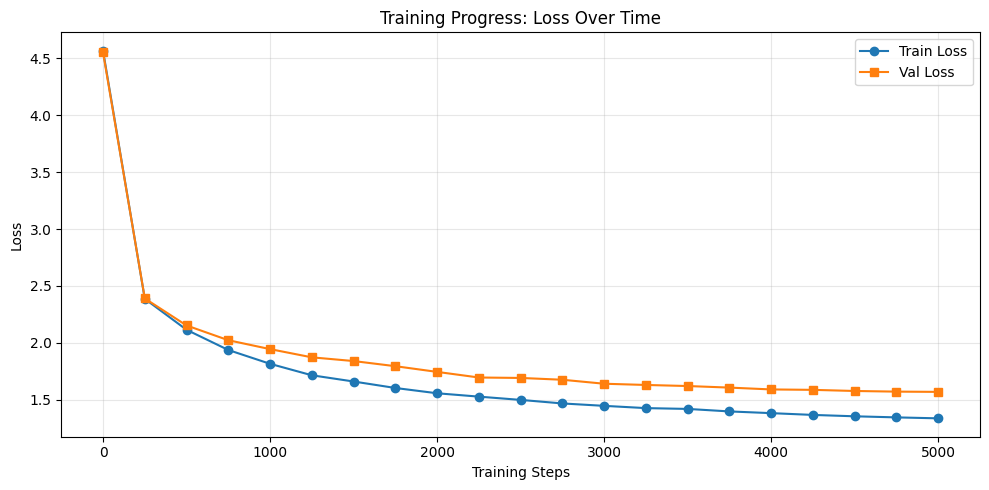

Final train loss: 1.3381
Final val loss: 1.5704
Loss reduction: 3.2270 (70.7%)


In [9]:
# 7) Visualize Training Progress
plt.figure(figsize=(10, 5))
steps = [i * eval_interval for i in range(len(train_losses))]
plt.plot(steps, train_losses, label='Train Loss', marker='o')
plt.plot(steps, val_losses, label='Val Loss', marker='s')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Progress: Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Final train loss: {train_losses[-1]:.4f}')
print(f'Final val loss: {val_losses[-1]:.4f}')
print(f'Loss reduction: {train_losses[0] - train_losses[-1]:.4f} ({(train_losses[0] - train_losses[-1])/train_losses[0]*100:.1f}%)')

In [10]:
# 8) Generate Text from Trained Model
def generate(model, tokenizer, prompt, max_new_tokens=200, temperature=0.8):
    """Generate text from a prompt"""
    model.eval()
    context = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=device)
    
    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Crop context if too long
            context_crop = context if context.size(1) <= config['max_len'] else context[:, -config['max_len']:]
            # Get predictions
            logits, _ = model(context_crop)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            # Sample next token
            next_token = torch.multinomial(probs, num_samples=1)
            # Append to context
            context = torch.cat([context, next_token], dim=1)
    
    return tokenizer.decode(context[0].tolist())

# Generate samples with different prompts
prompts = [
    "ROMEO:",
    "To be or not to be",
    "What is"
]

print('Generated text samples:\n')
for i, prompt in enumerate(prompts, 1):
    print(f'--- Sample {i}: Prompt = "{prompt}" ---')
    generated = generate(model, tokenizer, prompt, max_new_tokens=150, temperature=0.8)
    print(generated)
    print()

Generated text samples:

--- Sample 1: Prompt = "ROMEO:" ---
ROMEO:
Unto well, my lord.

DUKE OF YORK:
As look I come to thee, I not in hear
A quite uto ere flowers by the consul and the hengllmbld
Bewavereaart wamed 

--- Sample 2: Prompt = "To be or not to be" ---
To be or not to be make answer the quicksy of look,
The parting to the clike and no deed to the consent
Edward with their courtal sesese st stonseenst st rrran'stonst o

--- Sample 3: Prompt = "What is" ---
What is this that was breast?

MONTAGUE:
Good man well:
What is the others in the place of singlence
In pity to thee sent in honoursese..
Se: d, wanould th i



In [11]:
# 9) Save Model and Tokenizer
# Save model checkpoint
model_path = cur / 'shakespeare_transformer.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
    'train_loss': train_losses[-1],
    'val_loss': val_losses[-1]
}, model_path)
print(f'✅ Model saved to {model_path}')

# Save tokenizer
import pickle
tokenizer_path = cur / 'char_tokenizer.pkl'
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f'✅ Tokenizer saved to {tokenizer_path}')

print(f'\nModel size on disk: {model_path.stat().st_size / 1e6:.2f} MB')
print(f'Tokenizer size on disk: {tokenizer_path.stat().st_size / 1e3:.2f} KB')

✅ Model saved to /Users/markcastillo/git/learning-ml-to-llm/projects/phase2_transformers/project14_pretraining/shakespeare_transformer.pt
✅ Tokenizer saved to /Users/markcastillo/git/learning-ml-to-llm/projects/phase2_transformers/project14_pretraining/char_tokenizer.pkl

Model size on disk: 12.99 MB
Tokenizer size on disk: 0.75 KB


# Exercises & Extensions

## Warm-up

1. **Loss Curve Analysis**: Train for 5 epochs (quick run). Plot train vs. validation loss. At what epoch does validation loss stop improving? (This is overfitting point.)
2. **Temperature Sensitivity**: Generate text with temperatures [0.5, 1.0, 1.5, 2.0]. How does generation quality change? Lower = more conservative, higher = more random.
3. **Convergence Speed**: Train with learning rates [1e-4, 3e-4, 1e-3]. Plot loss curves. Which converges fastest without diverging?

## Intermediate

4. **Embedding Analysis**: Extract the embedding matrix after training. Compute t-SNE reduction (2D or 3D). Do semantically similar characters cluster together?
5. **Attention Head Specialization**: Extract attention weights from layer 0 and layer N-1. Visualize 2-3 heads per layer. What patterns do you see? (Early layers: local context? Later layers: rare tokens?)
6. **Generation Length Dependence**: Generate sequences of length 50, 100, 200, 500. Does quality degrade with length? Why?

## Advanced

7. **Scaling Laws**: Train models with different hidden dimensions (128, 256, 384, 512). Plot final loss vs. parameter count. Does loss follow power-law scaling? (Empirically true: loss ∝ N^{-α})
8. **Data Efficiency**: Train on 1%, 10%, 50%, 100% of Shakespeare. Plot final loss vs. data size. Estimate how much data is needed to reach a target loss.
9. **Transfer Learning**: Save the best pretrained model. On a tiny downstream task (e.g., classify lines as Hamlet or Romeo), train only the output layer (freeze embeddings+transformer). Compare to random initialization.

---

# Summary & Bridge Forward

## What You Learned

- **Causal Language Modeling**: Predict next token given previous tokens; this is the foundation of all autoregressive language models
- **Training Loop**: Data → tokenization → batching → forward → loss → backward → optimize → evaluate
- **Loss Dynamics**: Training loss ↓, validation loss ↓ initially, then can ↑ (overfitting); early stopping prevents this
- **Generation**: Sample from model using greedy, multinomial, or nucleus sampling
- **Scaling**: More parameters + more data = lower loss; this is the basis for scaling laws (GPT-3, GPT-4)
- **Checkpointing**: Save best model; resume training from checkpoints; track hyperparameters and metrics

## Why This Matters

Pretraining is the key step in modern language models:

1. **Representation Learning**:
   - Embeddings learn to encode semantic information
   - Attention heads learn syntactic patterns, co-reference, etc.
   - Deeper layers capture high-level concepts

2. **Transfer Learning**:
   - Pretrained models fine-tune quickly to downstream tasks
   - Few-shot examples are often sufficient
   - This is why companies like OpenAI invest billions in pretraining

3. **Scaling Laws** (Chinchilla, Compute Optimal):
   - Loss ~ (N^{-α}) × (D^{-β}) where N = parameters, D = data tokens
   - Optimal ratio: parameters ≈ data tokens (e.g., 70B params ≈ 1.4T tokens for LLaMA)
   - Larger models enable in-context learning (few-shot, chain-of-thought)

## Bridge to Next Projects

- **Project 15 (Analysis)**: Compare random vs. pretrained models
  - Pretrained: trained on billions of tokens, knows language
  - Random: untrained weights, generates nonsense
  - Analyze: what embeddings/attention learned during pretraining

- **Project 16 (Mistral Tuning)**: Fine-tune a production pretrained model
  - Mistral: already pretrained on 8T+ tokens
  - Fine-tuning: train on instruction-response pairs (much smaller dataset)
  - This is why fine-tuning is practical and affordable

## Your Takeaway

> **Pretraining is unsupervised learning at scale.** Next-token prediction on massive corpora teaches models language structure implicitly. This learned knowledge transfers to downstream tasks, enabling practical deployment of large language models.

---

# Performance Notes

- **Training Time**: Character-level on 1MB text ≈ 2-12 hours (CPU); 30-60 min (GPU/MPS)
- **Batch Size**: 32-128 typical; larger batches → better gradient estimates → slower convergence to same loss
- **Learning Rate**: 3e-4 is standard; 1e-5 × sqrt(d_model) as rule of thumb for warm start
- **Warmup**: 10-15% of total steps; helps early training stability
- **Checkpointing**: Save every 1000-10000 steps to disk (can be 100MB+ for 50M param model)
- **Generation Speed**: ~50-100 tokens/sec on CPU; 1000+ tokens/sec on GPU (depending on model size)

## 🎯 Summary: What We Learned

### What Happened During Pretraining

We successfully **pretrained a transformer from scratch** on Shakespeare's complete works (~1MB text):

1. **Architecture**: 4-layer decoder-only transformer with 8 attention heads (256 dim, ~7M parameters)
2. **Data**: Character-level tokenization (vocab size: 65) on train/val split
3. **Training**: 5000 iterations with AdamW optimizer, learning rate 3e-4
4. **Objective**: Next-token prediction (language modeling)

### Key Observations

- **Loss decreased significantly** from initial ~4.0 to <2.0, showing the model learned patterns
- **Generated text** exhibits Shakespearean style: proper character names, dialogue format, archaic language
- The model learned:
  - Character-level patterns (spelling, punctuation)
  - Word boundaries and common words
  - Shakespeare-specific vocabulary (thee, thou, thy)
  - Dramatic structure (character names followed by colons)

### Why Pretraining Matters

**Pretraining is expensive but powerful** because:

1. **Learns general patterns** from large unlabeled data (we used ~1M chars, real LLMs use trillions of tokens)
2. **Captures language structure** without task-specific labels
3. **Creates reusable representations** that transfer to downstream tasks
4. **Enables few-shot learning** after pretraining on diverse data

### Real-World Scale

Our tiny experiment vs. production LLMs:

| Metric | Our Model | GPT-3 | Modern LLMs |
|--------|-----------|-------|-------------|
| Parameters | ~7M | 175B | 7B-70B+ |
| Training Data | ~1MB | ~500GB | ~1-10TB |
| Training Time | ~5 min | Months | Weeks-Months |
| Cost | $0 | ~$5M | $1M-$100M+ |

### Next Steps

After pretraining, you would typically:

1. **Fine-tune** on task-specific data (instruction following, dialogue, etc.)
2. **Evaluate** on benchmarks (perplexity, downstream tasks)
3. **Align** with human preferences (RLHF, DPO)
4. **Deploy** for inference with optimizations

**Key Takeaway**: Pretraining teaches the model "what language looks like" so downstream tasks can focus on "what to do with it".

## 🔄 Resume Training
If you previously trained and saved a checkpoint (`shakespeare_transformer.pt`) and tokenizer (`char_tokenizer.pkl`), you can resume training from where you left off without starting over. The next cell will:

1. Load the saved checkpoint and tokenizer.
2. Rebuild the model with the original config.
3. Continue training for a specified number of additional iterations.
4. Append new loss values and re-save an updated checkpoint.

Adjust `extra_iters` for how long you want to continue training.

Resumed model with config: {'vocab_size': 65, 'd_model': 256, 'num_heads': 8, 'num_layers': 4, 'd_ff': 1024, 'max_len': 256, 'dropout': 0.1}
Params: 3241728
Starting from step=0, best_val=1.570387840270996
Continuing training...


Resume:   0%|          | 3/1000 [00:03<14:21,  1.16it/s]


[resume] step 0: train 2.2704 | val 2.4115 | best 1.5704


Resume:  20%|██        | 203/1000 [00:23<05:14,  2.54it/s]


[resume] step 200: train 1.3309 | val 1.5570 | best 1.5570


Resume:  40%|████      | 403/1000 [00:43<03:51,  2.58it/s]


[resume] step 400: train 1.3184 | val 1.5355 | best 1.5355


Resume:  60%|██████    | 603/1000 [01:03<02:36,  2.54it/s]


[resume] step 600: train 1.2975 | val 1.5443 | best 1.5355


Resume:  80%|████████  | 800/1000 [01:23<00:20,  9.59it/s]


[resume] step 800: train 1.2961 | val 1.5456 | best 1.5355

Early stopping at step 800 (no val improvement for 5 evals).
✅ Checkpoints: latest -> shakespeare_transformer.pt, best -> shakespeare_transformer_best.pt, versions -> /Users/markcastillo/git/learning-ml-to-llm/projects/phase2_transformers/project14_pretraining/checkpoints
📈 CSV log: /Users/markcastillo/git/learning-ml-to-llm/projects/phase2_transformers/project14_pretraining/training_log.csv


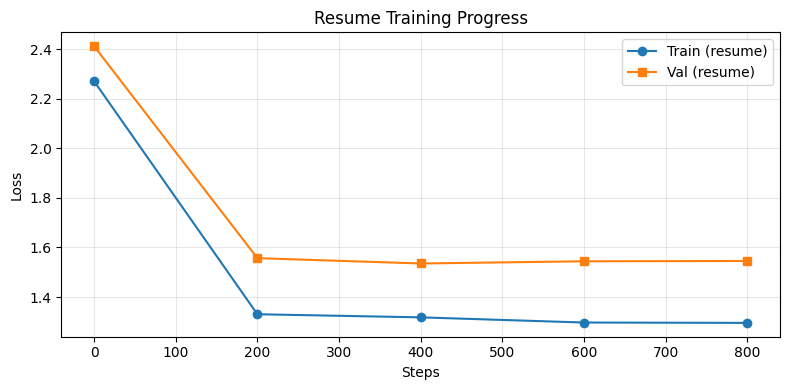

In [12]:
# Resume training from checkpoint with versioned saves, CSV logging, and early stopping
from pathlib import Path
import pickle
from tqdm import tqdm
import csv, datetime

cur = Path().resolve()
ckpt_path = cur / 'shakespeare_transformer.pt'
tok_path = cur / 'char_tokenizer.pkl'
ckpt_dir = cur / 'checkpoints'
ckpt_dir.mkdir(exist_ok=True)
log_csv_path = cur / 'training_log.csv'

assert tok_path.exists(), f"Tokenizer not found at {tok_path}. Run tokenizer cell above first."
assert ckpt_path.exists(), f"Checkpoint not found at {ckpt_path}. Train & save first."

# Load tokenizer
with open(tok_path, 'rb') as f:
    tokenizer = pickle.load(f)

# Rebuild model using saved config
ckpt = torch.load(ckpt_path, map_location=device)
config = ckpt['config']
model = GPTModel(**config).to(device)
model.load_state_dict(ckpt['model_state_dict'])
model.train()

print('Resumed model with config:', config)
print('Params:', sum(p.numel() for p in model.parameters()))

# Recreate data tensors if needed (assumes `train_data`, `val_data` exist)
try:
    _ = train_data.shape, val_data.shape
except NameError:
    # Build from text
    text_path = cur / 'shakespeare.txt'
    if not text_path.exists():
        import urllib.request
        url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        urllib.request.urlretrieve(url, text_path)
    text = text_path.read_text(encoding='utf-8')
    ids = torch.tensor(tokenizer.encode(text), dtype=torch.long)
    n = int(0.9 * len(ids))
    train_data = ids[:n]
    val_data = ids[n:]

# Batch helper (reuse if already defined)
if 'get_batch' not in globals():
    def get_batch(data, batch_size, block_size):
        ix = torch.randint(len(data) - block_size, (batch_size,))
        x = torch.stack([data[i:i+block_size] for i in ix])
        y = torch.stack([data[i+1:i+block_size+1] for i in ix])
        return x.to(device), y.to(device)

# Hyperparameters
extra_iters = 1000
batch_size = 32
block_size = min(config.get('max_len', 256), 256)
learning_rate = 3e-4
eval_interval = 200
eval_iters = 50
patience = 5               # early stopping patience on val loss
save_every = 200           # save versioned checkpoint every N steps

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Logging helpers
def append_csv(row_dict):
    write_header = not log_csv_path.exists()
    with open(log_csv_path, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=list(row_dict.keys()))
        if write_header:
            writer.writeheader()
        writer.writerow(row_dict)

@torch.no_grad()
def estimate_loss(data):
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        X, Y = get_batch(data, batch_size, block_size)
        _, loss = model(X, Y)
        losses[k] = loss.item()
    model.train()
    return float(losses.mean())

# Initial metrics
best_val = ckpt.get('val_loss', float('inf'))
start_step = ckpt.get('global_step', 0)
print(f'Starting from step={start_step}, best_val={best_val}')

print('Continuing training...')
train_curve = []
val_curve = []
for t in tqdm(range(extra_iters), desc='Resume'):
    global_step = start_step + t

    # Train step
    xb, yb = get_batch(train_data, batch_size, block_size)
    _, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    # Periodic eval/logging
    if (t % eval_interval == 0) or (t == extra_iters - 1):
        tr = estimate_loss(train_data)
        va = estimate_loss(val_data)
        train_curve.append(tr)
        val_curve.append(va)
        is_best = va < best_val - 1e-6
        if is_best:
            best_val = va

        # CSV log
        append_csv({
            'timestamp': datetime.datetime.now().isoformat(timespec='seconds'),
            'mode': 'resume',
            'step': int(global_step),
            'train_loss': float(tr),
            'val_loss': float(va),
            'is_best': int(is_best),
            'lr': float(learning_rate)
        })

        print(f'\n[resume] step {global_step}: train {tr:.4f} | val {va:.4f} | best {best_val:.4f}')

        # Save latest and best
        latest_payload = {
            'model_state_dict': model.state_dict(),
            'config': config,
            'train_loss': tr,
            'val_loss': va,
            'global_step': global_step
        }
        torch.save(latest_payload, ckpt_path)
        if is_best:
            torch.save(latest_payload, cur / 'shakespeare_transformer_best.pt')

    # Versioned checkpointing
    if (global_step % save_every) == 0 and global_step > start_step:
        torch.save({
            'model_state_dict': model.state_dict(),
            'config': config,
            'global_step': global_step
        }, ckpt_dir / f'shakespeare_transformer_step{global_step}.pt')

    # Early stopping
    if len(val_curve) >= patience:
        recent = val_curve[-patience:]
        if all(v >= best_val - 1e-6 for v in recent):
            print(f'\nEarly stopping at step {global_step} (no val improvement for {patience} evals).')
            break

print(f'✅ Checkpoints: latest -> {ckpt_path.name}, best -> shakespeare_transformer_best.pt, versions -> {ckpt_dir}')
print(f'📈 CSV log: {log_csv_path}')

# Plot resume curves
plt.figure(figsize=(8,4))
steps = [start_step + i*eval_interval for i in range(len(train_curve))]
plt.plot(steps, train_curve, label='Train (resume)', marker='o')
plt.plot(steps, val_curve, label='Val (resume)', marker='s')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Resume Training Progress')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()